# Topological regularization of bifurcating cell trajectory embedding

In this notebook, we show how a topological loss can be combined with a non-linear embedding procedure, as to regularize the embedding and better reflect the topological---in this case bifurcating---prior.

We start by setting the working directory and importing the necessary libraries.

## Setup

In [1]:
# Set working directory
import os
os.chdir("..")
import time

# Handling arrays and data.frames
import pandas as pd 
import numpy as np

# Pytorch compatible topology layer and losses
import torch
from topologylayer.nn import AlphaLayer
from Code.losses import DiagramLoss, umap_loss, zero_loss

# Ordinary and topologically regularized UMAP embedding
from Code.topembed import TopologicallyRegularizedUMAP
from Code.losses import get_topological_loss, combine_topological_losses
from Code.training import compute_embedding
import Data.datasets as datasets
import Code.visualization as viz

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Quantitative evaluation
from sklearn.svm import SVC
from Code.evaluation import evaluate_embeddings

import wandb
wandb.init(mode="disabled")

%matplotlib inline

In [2]:
sns.set_theme(context="paper", style="ticks",
              rc={"axes.spines.right": True,
                  "axes.spines.top": True},
              font_scale=3,
              )
output_path = "Output/CellBifurcating/"
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [3]:
umap = TopologicallyRegularizedUMAP(topo_loss=zero_loss, topo_weight=1) # Execute once for numba code compilation
_ = umap.initialize(np.array(np.random.rand(30, 5)))

## Parameters

In [4]:
topo_weight = 10
random_state = 42

method_name = "UMAP"
training_config = {
    'learning_rate': 0.1,
    'num_epochs': 100
}

method_config = {
     'emb_loss': True
}

data, labels = datasets.get_bifurcating_dataset()

## UMAP embedding

We start by loading the data and visualize it by means of its ordinary UMAP embedding.

Initial loss emb_loss: 9376.8556, topo_loss: 0.0000, weighted_topo_loss: 0.0000, total_loss: 9376.8556, weighted_total_loss: 9376.8556, 
Epoch   10: emb_loss: 8999.7567, topo_loss: 0.0000, weighted_topo_loss: 0.0000, total_loss: 8999.7567, weighted_total_loss: 8999.7567, 
Epoch   20: emb_loss: 8849.1089, topo_loss: 0.0000, weighted_topo_loss: 0.0000, total_loss: 8849.1089, weighted_total_loss: 8849.1089, 
Epoch   30: emb_loss: 8765.6341, topo_loss: 0.0000, weighted_topo_loss: 0.0000, total_loss: 8765.6341, weighted_total_loss: 8765.6341, 
Epoch   40: emb_loss: 8754.9841, topo_loss: 0.0000, weighted_topo_loss: 0.0000, total_loss: 8754.9841, weighted_total_loss: 8754.9841, 
Epoch   50: emb_loss: 8635.8993, topo_loss: 0.0000, weighted_topo_loss: 0.0000, total_loss: 8635.8993, weighted_total_loss: 8635.8993, 
Epoch   60: emb_loss: 8573.1702, topo_loss: 0.0000, weighted_topo_loss: 0.0000, total_loss: 8573.1702, weighted_total_loss: 8573.1702, 
Epoch   70: emb_loss: 8750.5564, topo_loss: 0.0

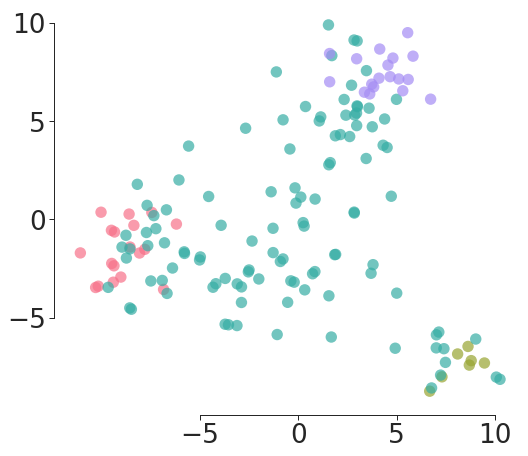

In [5]:
# Conduct ordinary UMAP embedding
Y_umap, result_df = Y, results_df = compute_embedding(data,
                                  method_name=method_name,
                                  method_config=method_config,
                                  loss_config={'zero_loss': {}},
                                  topo_weight=topo_weight,
                                  random_state=random_state,
                                  training_config=training_config,
                                  verbosity=1,
                                  )

p1 = viz.plot_paper(Y_umap, colors=labels)
plt.savefig(os.path.join(output_path, "CellBifUMAP.png"), dpi=200, bbox_inches='tight')

In [6]:
# Loss for UMAP embedding
toploss = combine_topological_losses([get_topological_loss("flare"), get_topological_loss("connected_component", sampling=False)])
print(f"Original UMAP embedding topo loss: {toploss(torch.tensor(Y_umap).type(torch.float))}")

Original UMAP embedding topo loss: 116.03113555908203


## Apply topological regularization to the embedding

We now show how we can bias a non-linear embedding using a loss function that captures our topological prior. This topological loss will be a linear combination of two separate losses:
- $\lambda_{\mathrm{flare}} <0$: A topological loss that encourages three clusters away from our embedding mean. It is proportional to the sum of persistence of the three most persisting components (neglecting the one with infinite persistence) in the fraction of our embedding that is sufficiently far from the embedding mean according to a proportional threshold $\tau_{\mathrm{flare}}$ fixed in advance.
- $\lambda_{\mathrm{connected}} >0$: A topological loss that encourages our embedded model to remain connected.

To obtain these losses, we require an additional layer that constructs the alpha complex from the embedding, from which subsequently persistent homology is computed.

We can now conduct the topologically regularized embedding as follows.

Initial loss emb_loss: 9376.8556, topo_loss: 141.2720, weighted_topo_loss: 1412.7205, total_loss: 9518.1276, weighted_total_loss: 10789.5760, 
Epoch   10: emb_loss: 9424.4723, topo_loss: 96.7179, weighted_topo_loss: 967.1793, total_loss: 9521.1903, weighted_total_loss: 10391.6516, 
Epoch   20: emb_loss: 9108.8904, topo_loss: 80.4746, weighted_topo_loss: 804.7465, total_loss: 9189.3650, weighted_total_loss: 9913.6368, 
Epoch   30: emb_loss: 9126.0845, topo_loss: 70.8925, weighted_topo_loss: 708.9247, total_loss: 9196.9770, weighted_total_loss: 9835.0092, 
Epoch   40: emb_loss: 9259.2575, topo_loss: 65.8575, weighted_topo_loss: 658.5751, total_loss: 9325.1150, weighted_total_loss: 9917.8326, 
Epoch   50: emb_loss: 9079.4796, topo_loss: 65.2973, weighted_topo_loss: 652.9735, total_loss: 9144.7770, weighted_total_loss: 9732.4531, 
Epoch   60: emb_loss: 9162.7401, topo_loss: 64.5305, weighted_topo_loss: 645.3046, total_loss: 9227.2706, weighted_total_loss: 9808.0447, 
Epoch   70: emb_loss: 

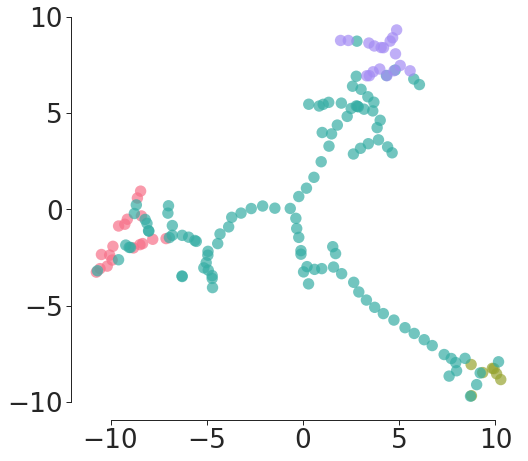

In [7]:
# Conduct topological regularization
loss_config = {"flare": {},
               "connected_component": {"sampling": False},
               }

Y_top, result_df = Y, results_df = compute_embedding(data,
                                  method_name=method_name,
                                  method_config=method_config,
                                  loss_config=loss_config,
                                  topo_weight=topo_weight,
                                  random_state=random_state,
                                  training_config=training_config,
                                  verbosity=1,
                                  )
p_top = viz.plot_paper(Y_top, colors=labels)
plt.savefig(os.path.join(output_path, "CellBifTop.png"))

## Compare with ordinary topological optimization

For comparison, we also conduct the same topological optimization procedure directly on the initialized embedding.

Initial loss emb_loss: 0.0000, topo_loss: 141.2720, weighted_topo_loss: 1412.7205, total_loss: 141.2720, weighted_total_loss: 1412.7205, 
Epoch   10: emb_loss: 0.0000, topo_loss: 90.1247, weighted_topo_loss: 901.2468, total_loss: 90.1247, weighted_total_loss: 901.2468, 
Epoch   20: emb_loss: 0.0000, topo_loss: 68.9748, weighted_topo_loss: 689.7478, total_loss: 68.9748, weighted_total_loss: 689.7478, 
Epoch   30: emb_loss: 0.0000, topo_loss: 57.7012, weighted_topo_loss: 577.0123, total_loss: 57.7012, weighted_total_loss: 577.0123, 
Epoch   40: emb_loss: 0.0000, topo_loss: 49.7171, weighted_topo_loss: 497.1706, total_loss: 49.7171, weighted_total_loss: 497.1706, 
Epoch   50: emb_loss: 0.0000, topo_loss: 43.6607, weighted_topo_loss: 436.6075, total_loss: 43.6607, weighted_total_loss: 436.6075, 
Epoch   60: emb_loss: 0.0000, topo_loss: 40.2216, weighted_topo_loss: 402.2164, total_loss: 40.2216, weighted_total_loss: 402.2164, 
Epoch   70: emb_loss: 0.0000, topo_loss: 36.8883, weighted_topo_

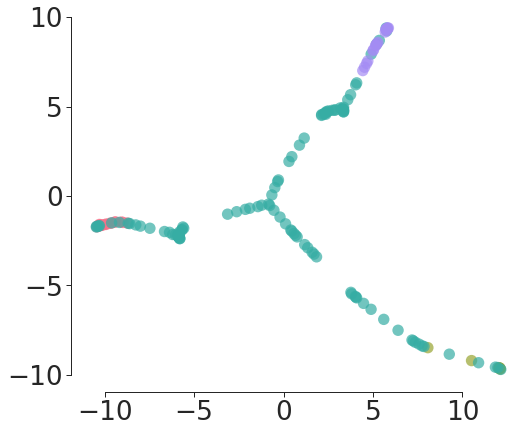

In [8]:
# Conduct topological regularization
loss_config = {"flare": {},
               "connected_component": {"sampling": False},
               }
Y_opt, result_df = Y, results_df = compute_embedding(data,
                                  method_name=method_name,
                                  method_config={"emb_loss": False},
                                  loss_config=loss_config,
                                  topo_weight=topo_weight,
                                  random_state=random_state,
                                  training_config=training_config,
                                  verbosity=1,
                                  emb_init=Y_umap
                                  )

p_opt = viz.plot_paper(Y_opt, colors=labels)
plt.savefig(os.path.join(output_path, "CellBifUMAPopt.png"))

We observe that without the embedding loss, the represented topologies are more fragmented and more interior points representing the bifurcation are pulled towards the ends.

## Quantitative evaluation

Finally, we compare if the topologically regularized embedding improves on the ordinary UMAP embedding for predicting data point labels.

In [9]:
# Machine learning model to be used for label prediction
Ys = {"umap": Y_umap, "top. opt.": Y_opt, "top. reg.": Y_top}
model = SVC()
scoring = "accuracy"

# Hyperparameters for quantitative evaluation
ntimes = 100
test_frac = 0.1
params = {"C":[0.01, 0.1, 1, 10, 100]}

# Obtain performances over multiple train-test splits
performances = evaluate_embeddings(Ys, labels, model, scoring, params=params, stratify=labels,
                                   ntimes=ntimes, test_frac=test_frac, random_state=42)

# View resulting performances
pd.concat([pd.DataFrame({"mean":performances.mean(axis=0)}),
           pd.DataFrame({"std":performances.std(axis=0)})], axis=1)\
            .style.highlight_max(subset="mean", color="lightgreen", axis=0)

,mean,std
umap,0.781250,0.080687
top. opt.,0.846875,0.074522
top. reg.,0.821875,0.077634


## Varying threshold tau in flare loss

We explore how topological regularization reacts to different thresholds $\tau$ that are used to topologically optimize for a flare. The different embeddings are obtained and visualized as follows.

Initial loss emb_loss: 9376.8556, topo_loss: 145.8245, weighted_topo_loss: 1458.2452, total_loss: 9522.6801, weighted_total_loss: 10835.1008, 
Epoch   10: emb_loss: 9231.0677, topo_loss: 101.3120, weighted_topo_loss: 1013.1198, total_loss: 9332.3796, weighted_total_loss: 10244.1875, 
Epoch   20: emb_loss: 9372.4831, topo_loss: 87.1981, weighted_topo_loss: 871.9805, total_loss: 9459.6812, weighted_total_loss: 10244.4636, 
Epoch   30: emb_loss: 9291.7561, topo_loss: 77.2717, weighted_topo_loss: 772.7174, total_loss: 9369.0278, weighted_total_loss: 10064.4734, 
Epoch   40: emb_loss: 9205.2356, topo_loss: 73.5094, weighted_topo_loss: 735.0938, total_loss: 9278.7450, weighted_total_loss: 9940.3294, 
Epoch   50: emb_loss: 9203.0538, topo_loss: 72.9967, weighted_topo_loss: 729.9670, total_loss: 9276.0505, weighted_total_loss: 9933.0209, 
Epoch   60: emb_loss: 8975.4468, topo_loss: 73.0011, weighted_topo_loss: 730.0105, total_loss: 9048.4479, weighted_total_loss: 9705.4573, 
Epoch   70: emb_lo

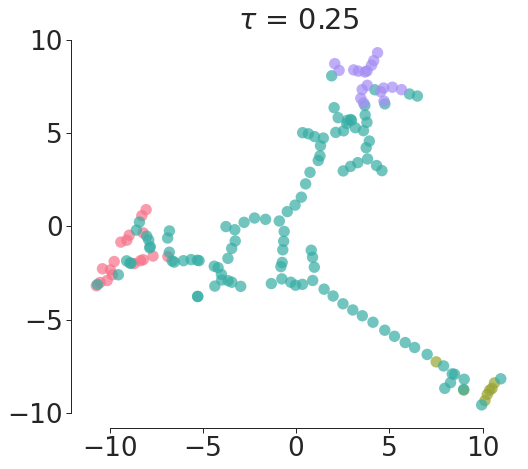

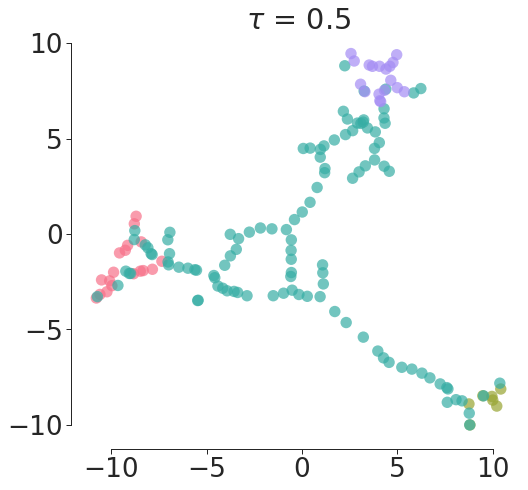

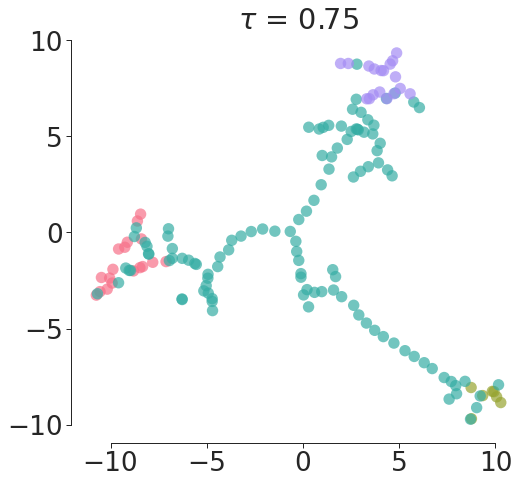

In [10]:
# Conduct topological regularization for flare thresholds tau
taus = [0.75, 0.5, 0.25] # note that tau (main paper) = 1 - tau (notebook)
Y_taus = []

def flare_sampling(thres):
    def sample(Y):
        f = torch.norm(Y - torch.mean(Y, dim=0), dim=1)
        f /= torch.max(f)
        return f > thres
    return sample

for tau in taus:
    # Conduct topological regularization
    loss_config = {"flare": {"sampling_fn": flare_sampling(tau)},
                "connected_component": {"sampling": False},
                }
    Y, _ = Y, results_df = compute_embedding(data,
                                  method_name=method_name,
                                  method_config=method_config,
                                  loss_config=loss_config,
                                  topo_weight=topo_weight,
                                  random_state=random_state,
                                  training_config=training_config,
                                  verbosity=1,
                                  emb_init=Y_umap
                                  )
    p = viz.plot_paper(Y, colors=labels, title=r"$\tau$ = " + str(1 - tau))
    plt.savefig(os.path.join(output_path, f"CellBifTau_{str.replace(str(1 - tau), '.', '_')}.png"))

## Topological regularization for different powers of the persistence lifetime
Different powers of the persistence may result in different behavior of the topological regularization. We explore this (keeping all other hyperparameters identical) as follows.

Initial loss emb_loss: 9376.8556, topo_loss: 136.1457, weighted_topo_loss: 1361.4574, total_loss: 9513.0013, weighted_total_loss: 10738.3130, 
Epoch   10: emb_loss: 9213.1345, topo_loss: 114.9185, weighted_topo_loss: 1149.1847, total_loss: 9328.0530, weighted_total_loss: 10362.3192, 
Epoch   20: emb_loss: 9128.9903, topo_loss: 107.2486, weighted_topo_loss: 1072.4857, total_loss: 9236.2389, weighted_total_loss: 10201.4759, 
Epoch   30: emb_loss: 8986.9638, topo_loss: 101.8641, weighted_topo_loss: 1018.6411, total_loss: 9088.8279, weighted_total_loss: 10005.6048, 
Epoch   40: emb_loss: 8885.9540, topo_loss: 99.9621, weighted_topo_loss: 999.6206, total_loss: 8985.9160, weighted_total_loss: 9885.5746, 
Epoch   50: emb_loss: 8906.3691, topo_loss: 97.1754, weighted_topo_loss: 971.7545, total_loss: 9003.5446, weighted_total_loss: 9878.1236, 
Epoch   60: emb_loss: 8878.5331, topo_loss: 99.3076, weighted_topo_loss: 993.0765, total_loss: 8977.8407, weighted_total_loss: 9871.6095, 
Epoch   70: em

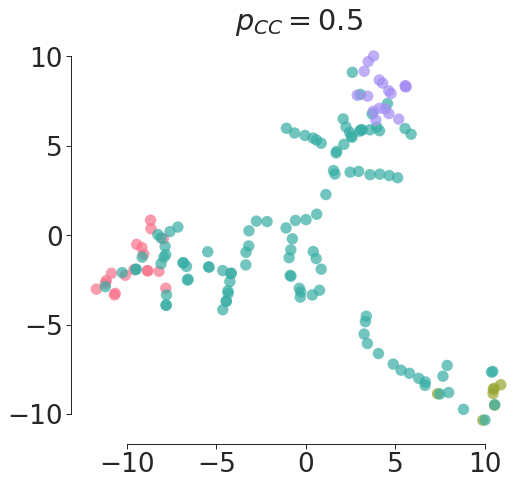

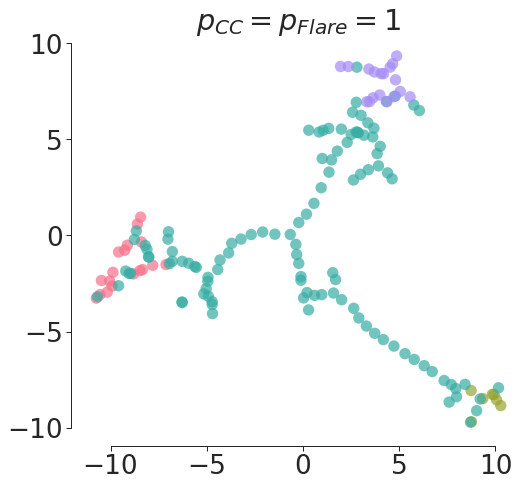

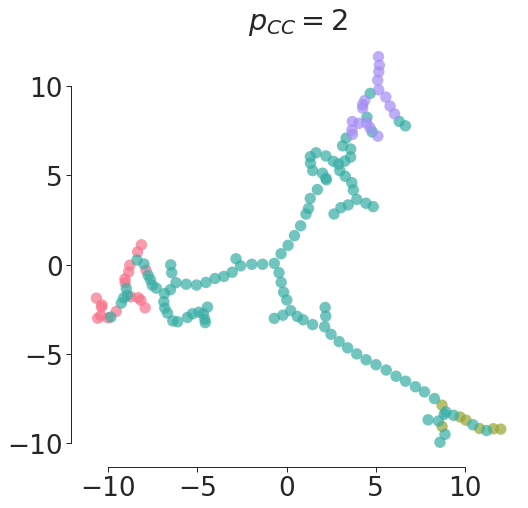

In [11]:
# Conduct topological regularization for different powers of the persistence lifetime
powers = [1 / 2, 1, 2] # p = 1 equals or previous case, which we include for easy comparison

for p in powers:
    # Conduct topological regularization
    loss_config = {"flare": {},
                "connected_component": {"sampling": False,
                                        "exponent": p},
                }
    Y, _ = Y, results_df = compute_embedding(data,
                                    method_name=method_name,
                                    method_config=method_config,
                                    loss_config=loss_config,
                                    topo_weight=topo_weight,
                                    random_state=random_state,
                                    training_config=training_config,
                                    verbosity=1,
                                    emb_init=Y_umap
                                    )
    if p == 1:
        title = r"$p_{CC} = p_{Flare} = $" + str(p)
    else:
        title = r"$p_{CC} = $" + str(p)
    plot = viz.plot_paper(Y, colors=labels, title=title)
    plt.savefig(os.path.join(output_path, f"CellBifConn_p_{str.replace(str(p), '.', '_')}.png"))

We observe that a large exponent for the finite 0-dimensional persistence reduces the size of gaps between individual points. A small exponent does not penalize larger gaps and results in more overlap (decreasing gaps between already close points).

We investigate different exponents for the flare loss as well. As the flare loss measures the persistence of the third most prominent cycle we expect the three endpoints of the arms to be further away with a large exponent (or even separate from the main component).

Initial loss emb_loss: 9376.8556, topo_loss: 145.1615, weighted_topo_loss: 1451.6153, total_loss: 9522.0171, weighted_total_loss: 10828.4708, 
Epoch   10: emb_loss: 9177.4956, topo_loss: 101.4350, weighted_topo_loss: 1014.3497, total_loss: 9278.9306, weighted_total_loss: 10191.8453, 
Epoch   20: emb_loss: 9242.5654, topo_loss: 85.2446, weighted_topo_loss: 852.4464, total_loss: 9327.8100, weighted_total_loss: 10095.0118, 
Epoch   30: emb_loss: 9252.1490, topo_loss: 75.7611, weighted_topo_loss: 757.6109, total_loss: 9327.9101, weighted_total_loss: 10009.7600, 
Epoch   40: emb_loss: 9156.2831, topo_loss: 71.5449, weighted_topo_loss: 715.4488, total_loss: 9227.8280, weighted_total_loss: 9871.7318, 
Epoch   50: emb_loss: 9340.8936, topo_loss: 70.2082, weighted_topo_loss: 702.0824, total_loss: 9411.1018, weighted_total_loss: 10042.9760, 
Epoch   60: emb_loss: 9075.6787, topo_loss: 69.0607, weighted_topo_loss: 690.6074, total_loss: 9144.7394, weighted_total_loss: 9766.2861, 
Epoch   70: emb_l

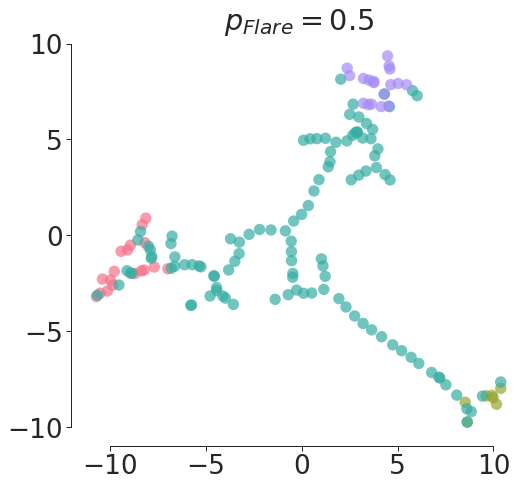

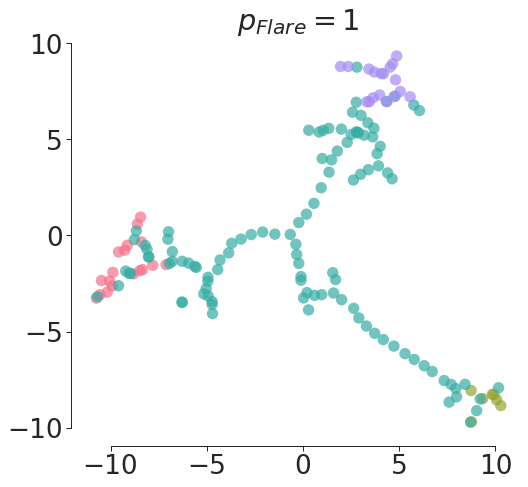

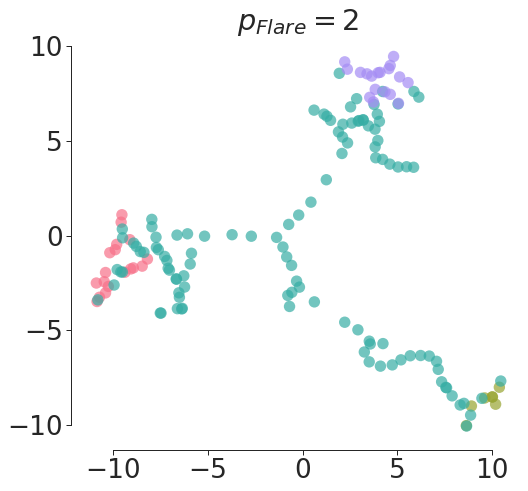

In [12]:
# Conduct topological regularization for different powers of the persistence lifetime
powers = [1 / 2, 1, 2] # p = 1 equals or previous case, which we include for easy comparison

for p in powers:
    # Conduct topological regularization
    loss_config = {"flare": {"exponent": p},
                "connected_component": {"sampling": False},
                }
    Y, _ = Y, results_df = compute_embedding(data,
                                  method_name=method_name,
                                  method_config=method_config,
                                  loss_config=loss_config,
                                  topo_weight=topo_weight,
                                  random_state=random_state,
                                  training_config=training_config,
                                  verbosity=1,
                                  emb_init=Y_umap
                                  )
    plot = viz.plot_paper(Y, colors=labels, title=r"$p_{Flare} = $" + str(p))
    plt.savefig(os.path.join(output_path, f"CellBifFlare_p_{str.replace(str(p), '.', '_')}.png"))

## Topological regularization for different shape prior
Finally, we study how the tologically regularized embedding varies for a different potentially wrong prior. In particular, we study the topologically regularized embedding when the topological loss function is designed to ensure that the persistence of the most prominent cycle is high. All other hyperparameters will be kept equal.

We explore the topologically regularized embedding for multiple epochs.

Initial loss emb_loss: 9376.8556, topo_loss: -0.9282, weighted_topo_loss: -9.2815, total_loss: 9375.9274, weighted_total_loss: 9367.5740, 
Epoch   10: emb_loss: 9136.6318, topo_loss: -0.7969, weighted_topo_loss: -7.9687, total_loss: 9135.8349, weighted_total_loss: 9128.6630, 
Epoch   20: emb_loss: 8857.1501, topo_loss: -0.9971, weighted_topo_loss: -9.9715, total_loss: 8856.1529, weighted_total_loss: 8847.1786, 
Epoch   30: emb_loss: 8833.8662, topo_loss: -0.5870, weighted_topo_loss: -5.8699, total_loss: 8833.2792, weighted_total_loss: 8827.9964, 
Epoch   40: emb_loss: 8583.0752, topo_loss: -0.5447, weighted_topo_loss: -5.4474, total_loss: 8582.5305, weighted_total_loss: 8577.6279, 
Epoch   50: emb_loss: 8846.5409, topo_loss: -0.8234, weighted_topo_loss: -8.2343, total_loss: 8845.7175, weighted_total_loss: 8838.3066, 
Epoch   60: emb_loss: 8608.6013, topo_loss: -0.9299, weighted_topo_loss: -9.2985, total_loss: 8607.6715, weighted_total_loss: 8599.3028, 
Epoch   70: emb_loss: 8705.9451, 

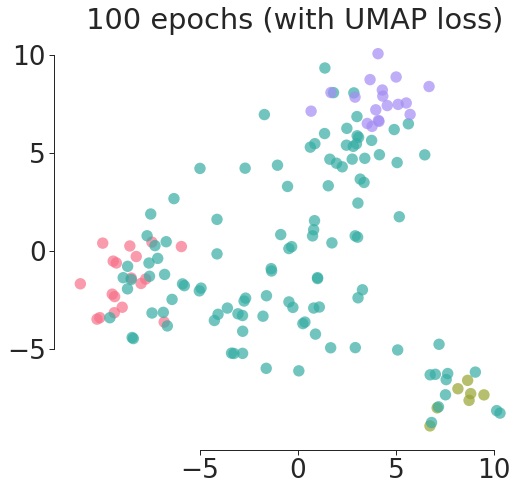

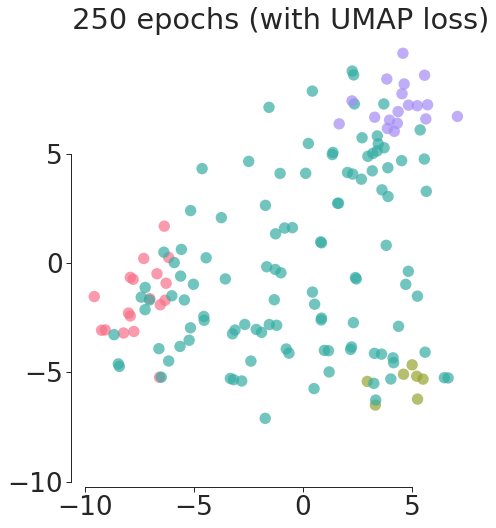

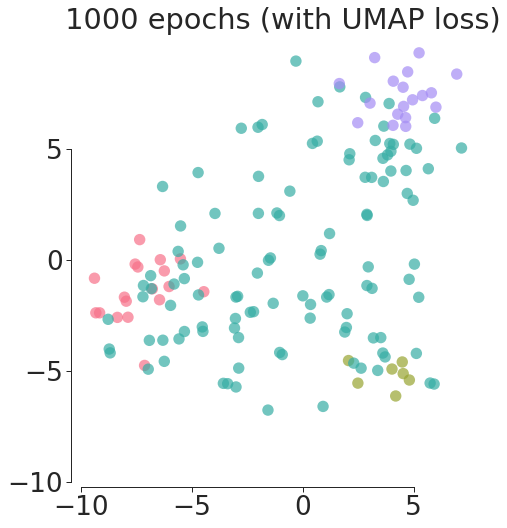

In [13]:
loss_config = {"one_circle": {"sampling": True,
                              "sampling_frac": 0.25,
                              "sampling_rep": 10}}
num_epochs = [100, 250, 1000]

for epochs in num_epochs:
    Y, _ = compute_embedding(data,
                             method_name=method_name,
                             method_config=method_config,
                             loss_config=loss_config,
                             topo_weight=topo_weight,
                             random_state=random_state,
                             training_config={
                                 'learning_rate': 0.1,
                                 'num_epochs': epochs},
                             verbosity=1,
                             emb_init=Y_umap
                             )
    p = viz.plot_paper(
        Y, colors=labels, title=f" {epochs} epochs (with UMAP loss)")
    plt.savefig(os.path.join(
        output_path, f"CellBifRegCircle_{epochs}_epochs.png"))


We observe that the cycle struggles to enlarge for higher number of epochs. The fact that this is due to the inclusion of the UMAP loss, can be confirmed by conducting the same topological optimization without the UMAP loss.

Initial loss emb_loss: 0.0000, topo_loss: -0.9358, weighted_topo_loss: -9.3578, total_loss: -0.9358, weighted_total_loss: -9.3578, 
Epoch   10: emb_loss: 0.0000, topo_loss: -1.2876, weighted_topo_loss: -12.8761, total_loss: -1.2876, weighted_total_loss: -12.8761, 
Epoch   20: emb_loss: 0.0000, topo_loss: -1.7083, weighted_topo_loss: -17.0833, total_loss: -1.7083, weighted_total_loss: -17.0833, 
Epoch   30: emb_loss: 0.0000, topo_loss: -1.4686, weighted_topo_loss: -14.6855, total_loss: -1.4686, weighted_total_loss: -14.6855, 
Epoch   40: emb_loss: 0.0000, topo_loss: -1.5539, weighted_topo_loss: -15.5392, total_loss: -1.5539, weighted_total_loss: -15.5392, 
Epoch   50: emb_loss: 0.0000, topo_loss: -3.1310, weighted_topo_loss: -31.3104, total_loss: -3.1310, weighted_total_loss: -31.3104, 
Epoch   60: emb_loss: 0.0000, topo_loss: -2.6423, weighted_topo_loss: -26.4229, total_loss: -2.6423, weighted_total_loss: -26.4229, 
Epoch   70: emb_loss: 0.0000, topo_loss: -4.8884, weighted_topo_loss: 

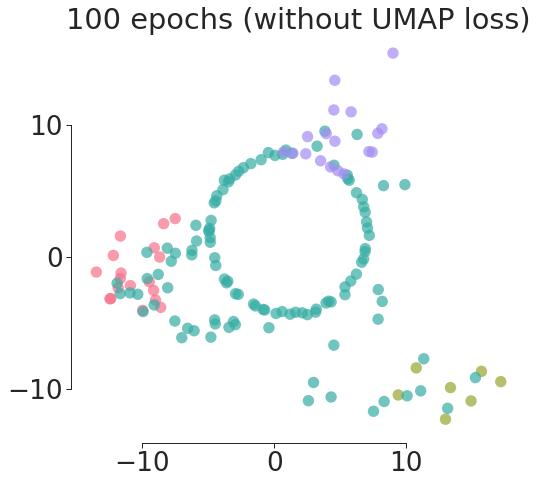

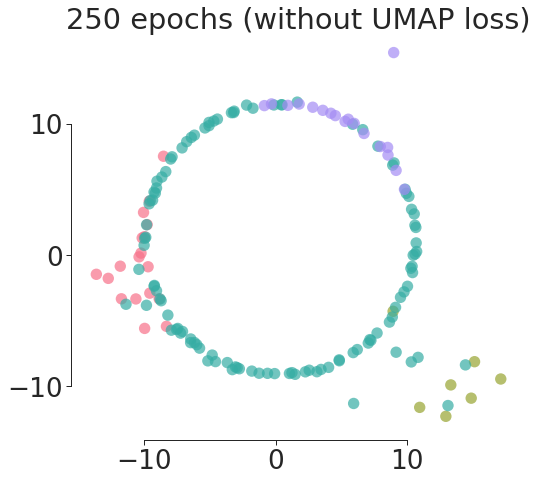

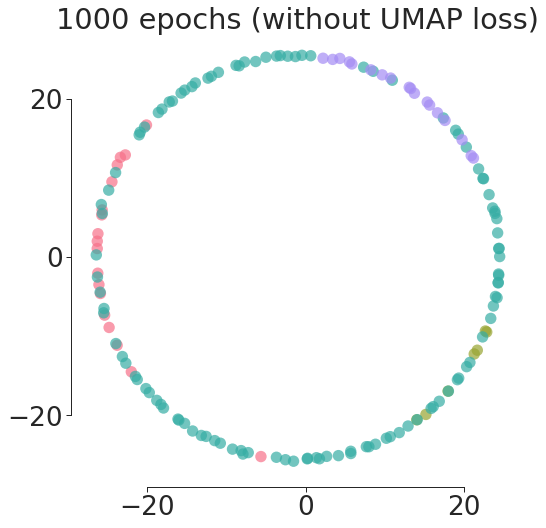

In [14]:
num_epochs = [100, 250, 1000]
for epochs in num_epochs:
    Y, _ = compute_embedding(data,
                             method_name=method_name,
                             method_config={'emb_loss': False},
                             loss_config=loss_config,
                             topo_weight=topo_weight,
                             random_state=random_state,
                             training_config={
                                 'learning_rate': 0.1,
                                 'num_epochs': epochs
                             },
                             verbosity=1,
                             emb_init=Y_umap
                             )
    p = viz.plot_paper(
        Y, colors=labels, title=f"{epochs} epochs (without UMAP loss)")
    plt.savefig(os.path.join(
        output_path, f"CellBifOptCircle_{epochs}_epochs.png"))


Naturally, by increasing the topological regularization strenght, representations of false topological models may still be obtained. We will explore how this can be suggested from the data as follows.

Initial loss emb_loss: 9376.8556, topo_loss: -0.9265, weighted_topo_loss: -9.2647, total_loss: 9375.9291, weighted_total_loss: 9367.5908, 
Epoch   25: emb_loss: 8931.0127, topo_loss: -0.9107, weighted_topo_loss: -9.1070, total_loss: 8930.1020, weighted_total_loss: 8921.9057, 
Epoch   50: emb_loss: 8663.7780, topo_loss: -0.8337, weighted_topo_loss: -8.3375, total_loss: 8662.9442, weighted_total_loss: 8655.4405, 
Epoch   75: emb_loss: 8675.2093, topo_loss: -1.0080, weighted_topo_loss: -10.0803, total_loss: 8674.2013, weighted_total_loss: 8665.1291, 
Epoch  100: emb_loss: 8506.4997, topo_loss: -1.0286, weighted_topo_loss: -10.2856, total_loss: 8505.4711, weighted_total_loss: 8496.2141, 
Epoch  125: emb_loss: 8580.1169, topo_loss: -0.7350, weighted_topo_loss: -7.3501, total_loss: 8579.3819, weighted_total_loss: 8572.7668, 
Epoch  150: emb_loss: 8540.1108, topo_loss: -0.6819, weighted_topo_loss: -6.8188, total_loss: 8539.4289, weighted_total_loss: 8533.2920, 
Epoch  175: emb_loss: 8300.7857

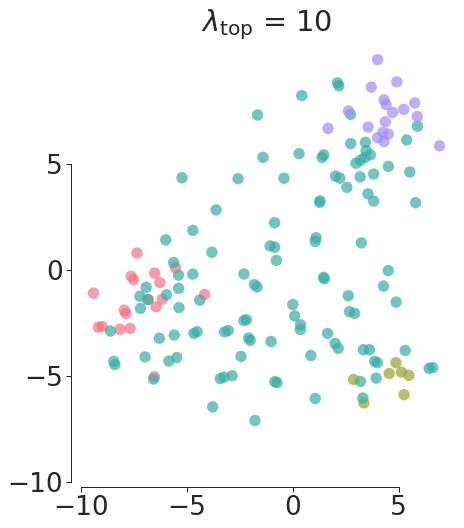

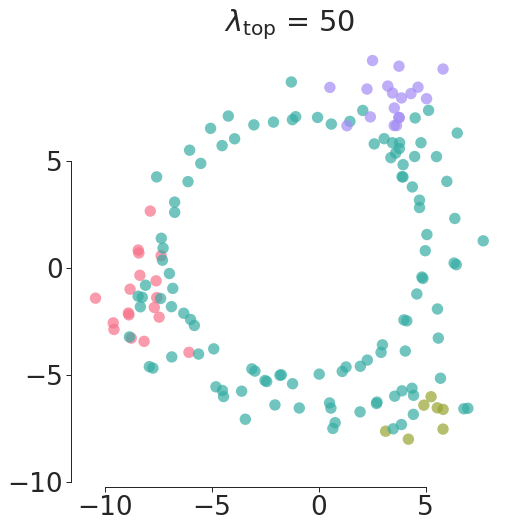

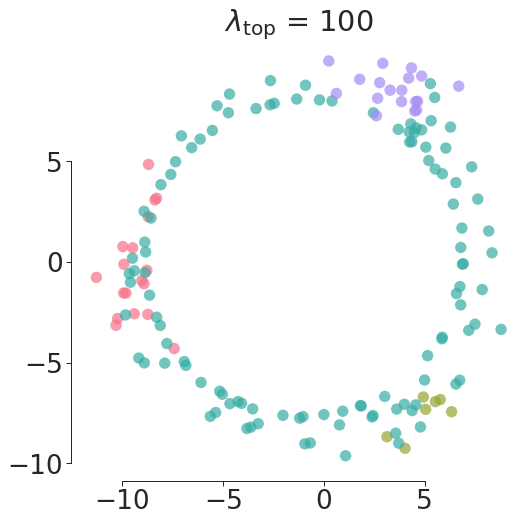

In [15]:
loss_config = {"one_circle": {"sampling": True,
                              "sampling_frac": 0.25,
                              "sampling_rep": 10}}
topo_weights = [10, 50, 100]
num_epochs = 250

losses_lambdas = {}
for weight in topo_weights:
    Y, _, loss_df = compute_embedding(data,
                                        method_name=method_name,
                                        method_config=method_config,
                                        loss_config=loss_config,
                                        topo_weight=weight,
                                        random_state=random_state,
                                        training_config={
                                            'learning_rate': 0.1,
                                            'num_epochs': num_epochs
                                        },
                                        verbosity=1,
                                        emb_init=Y_umap,
                                        return_loss_history=True
                                        )

    losses_lambdas[weight] = loss_df
    p = viz.plot_paper(
        Y, colors=labels, title=f"$\lambda_{{\mathrm{{top}}}}$ = {weight}")
    plt.savefig(os.path.join(
        output_path, f"CellBifRegCircle_topoweight_{weight}.png"), dpi=200, bbox_inches='tight')


We see that for low regularization strengths, the topological prior has little to no impact on the embedding, whereas for too high regularization strengths, the cycle becomes an unnatural representation of the data, as most points remain clustered together. We can investigate the evolution of the losses during optimization for the different regularization strengths as follows.

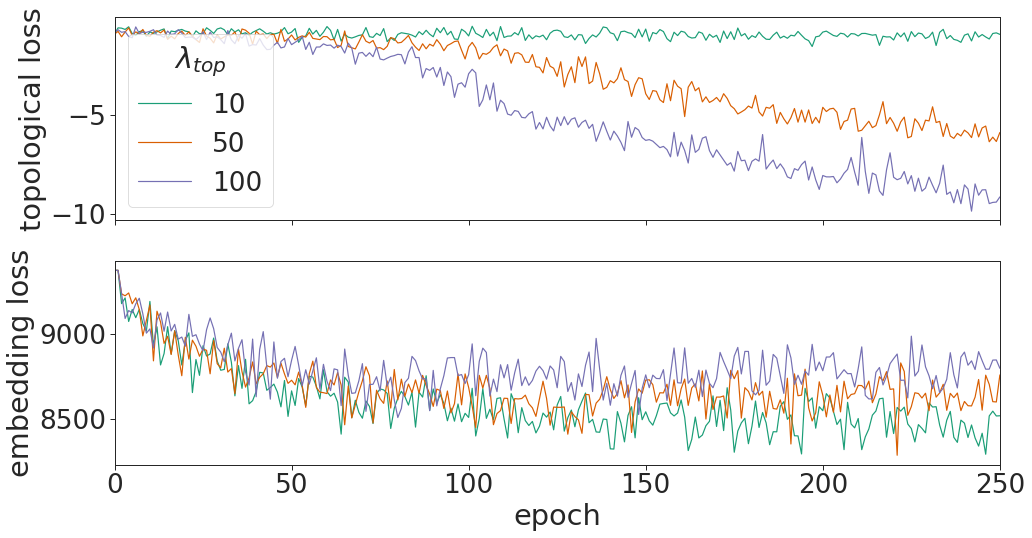

In [16]:
losses_df = pd.DataFrame({})
for t in topo_weights:
    tmp_df = pd.DataFrame(losses_lambdas[t])
    tmp_df["topo_weight"] = np.repeat([t], len(losses_lambdas[t]))
    losses_df = losses_df.append(tmp_df, ignore_index=True)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
sns.lineplot(data=losses_df, x="epoch", y="topo_loss", hue="topo_weight", palette="Dark2", ax=ax1)
ax1.set_ylabel("topological loss")
ax1.legend(loc='lower left', title=r"$\lambda_{top}$")
ax1.set_xlim((0, max(losses_df["epoch"])))
#ax1.set_xticks(())

sns.lineplot(data=losses_df, x="epoch", y="emb_loss", hue="topo_weight", palette="Dark2", ax=ax2, legend=False)
ax2.set_ylabel("embedding loss")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "CellBifCycleLoss.png"))